In [44]:
import os
import io
import re
import time
import itertools
import operator
from collections import Counter
from langdetect import detect
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
import numpy as np
import PyPDF2
import spacy
import textract
from difflib import SequenceMatcher
import en_core_web_sm
nlp = en_core_web_sm.load()

#Data Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lingadhar_duggirala\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [3]:
flname='C:/Users/lingadhar_duggirala/Desktop/Metadata_Validation/FDCA3Cos with AlternateNames.xlsx'
comp_master=pd.read_excel(flname)
comp_master=comp_master[["CompanyId","Company Name","ALTERNATENAME"]]
comp_master["compnmlower"]=comp_master["Company Name"].str.lower()
comp_master["alternatenamelower"]=comp_master["ALTERNATENAME"].str.lower()
comp_master=comp_master.drop(comp_master[(comp_master["compnmlower"].str.startswith('u.s. securities'))&(comp_master.compnmlower.notnull())].index)
comp_master["compnmlower"]=comp_master.compnmlower.fillna(value="UNK")
comp_master["Company Name"]=comp_master["Company Name"].fillna(value="UNK")
comp_master["ALTERNATENAME"]=comp_master["ALTERNATENAME"].fillna(value="UNK")
comp_master["alternatenamelower"]=comp_master["alternatenamelower"].fillna(value="UNK")

In [4]:
sec_metadata=pd.read_excel("C:\\Users\\lingadhar_duggirala\\Desktop\\Metadata_Validation\\Sample Metadata SEC_Final.xlsx")

In [8]:
sec_metadata.head(2)

,DocumentId,doc cnt,VersionId,CompanyId,Company Name,documentToObjectRelId,elementGroupId,PeriodOfReport,Language,FilingDate,FilingDateSource,PeriodType,Has Income Statement Flag,Is Preliminary Flag,Is Amendment Flag,Is Errata Amendment Flag,Has Notes Flag,Has Audited Financials Flag,Category
0,322994151,4,97924048,24927252,Noranda Alumina LLC,347206249,-1295509969,2009-08-31,English,2010-05-14 16:28:42,Filing date on the website,Quarter,True,0.0,0.0,0.0,1.0,0.0,VALIDATION
1,322994151,4,97924048,24927252,Noranda Alumina LLC,347206249,-1295509965,2008-12-31,English,2010-05-14 16:28:42,Filing date on the website,Annual,True,0.0,0.0,0.0,1.0,1.0,TRAIN


In [105]:
sec_metadata=sec_metadata[["VersionId","PeriodType","Category"]]

In [106]:
sec_metadata["PeriodType"]=sec_metadata.PeriodType.fillna("UNK")

In [107]:
sec_metadata.PeriodType.value_counts()

Quarter       2073
Annual         877
UNK             99
SemiAnnual      22
Name: PeriodType, dtype: int64

In [222]:
sec_metadata_train=sec_metadata[sec_metadata.Category=="TRAIN"]

In [264]:
sec_metadata_test=sec_metadata[sec_metadata.Category=="TEST"]

In [265]:
sec_metadata_test.shape

(232, 3)

In [267]:
sec_metadata_test.PeriodType.value_counts()

Quarter       171
Annual         54
UNK             6
SemiAnnual      1
Name: PeriodType, dtype: int64

In [212]:
sec_metadata_train.shape

(103, 3)

In [266]:
sec_metadata_train.PeriodType.value_counts()

1    30
2     7
3     3
Name: PeriodType, dtype: int64

In [224]:
sec_metadata_train.head(3)

,VersionId,PeriodType,Category
662,273075380,Annual,TRAIN
697,350666530,Annual,TRAIN
755,426757198,Annual,TRAIN


In [155]:
sec_metadata[sec_metadata.Category=="TRAIN"].shape

(103, 3)

In [225]:
sec_metadata_train=sec_metadata_train.drop_duplicates()

In [268]:
sec_metadata_test=sec_metadata_test.drop_duplicates()

In [226]:
sec_metadata_train=sec_metadata_train.groupby('VersionId', as_index=False).agg(lambda x: ', '.join(set(x.astype(str))))

In [269]:
sec_metadata_test=sec_metadata_test.groupby('VersionId', as_index=False).agg(lambda x: ', '.join(set(x.astype(str))))

In [227]:
sec_metadata_train.head(2)

,VersionId,PeriodType,Category
0,273075380,Annual,TRAIN
1,350666530,Annual,TRAIN


In [271]:
sec_metadata_test.shape

(112, 3)

In [228]:
sec_metadata_train.PeriodType.value_counts()

Annual             28
Quarter             7
Annual, Quarter     3
UNK                 1
Annual, UNK         1
Name: PeriodType, dtype: int64

In [229]:
#sec_metadata_train['PeriodType']=sec_metadata_train['PeriodType'].map(lambda x: str(x)[:-2])
#sec_metadata_train['PeriodType']=sec_metadata_train['PeriodType'].map(lambda x: str(x)[2:])
#sec_metadata_train['PeriodType'] = sec_metadata_train['PeriodType'].str.replace("'", '')
sec_metadata_train['PeriodType'] = sec_metadata_train['PeriodType'].str.replace(' ', '')
sec_metadata_train['PeriodType'] = sec_metadata_train['PeriodType'].str.replace('Quarter,Annual','Annual,Quarter')
sec_metadata_train['PeriodType'] = sec_metadata_train['PeriodType'].str.replace('UNK,Annual','Annual')
sec_metadata_train['PeriodType'] = np.where((sec_metadata_train['PeriodType']=="UNK"),"Annual",sec_metadata_train['PeriodType'])
sec_metadata_train["PeriodType"]=sec_metadata_train.PeriodType.replace(to_replace="Annual",value=1)
sec_metadata_train["PeriodType"]=sec_metadata_train.PeriodType.replace(to_replace="Quarter",value=2)
sec_metadata_train["PeriodType"]=sec_metadata_train.PeriodType.replace(to_replace="Annual,Quarter",value=3)

In [272]:
sec_metadata_test['PeriodType'] = sec_metadata_test['PeriodType'].str.replace(' ', '')
sec_metadata_test['PeriodType'] = sec_metadata_test['PeriodType'].str.replace('Quarter,Annual','Annual,Quarter')
sec_metadata_test['PeriodType'] = sec_metadata_test['PeriodType'].str.replace('UNK,Annual','Annual')
sec_metadata_test['PeriodType'] = np.where((sec_metadata_test['PeriodType']=="UNK"),"Annual",sec_metadata_test['PeriodType'])
sec_metadata_test["PeriodType"]=sec_metadata_test.PeriodType.replace(to_replace="Annual",value=1)
sec_metadata_test["PeriodType"]=sec_metadata_test.PeriodType.replace(to_replace="Quarter",value=2)
sec_metadata_test["PeriodType"]=sec_metadata_test.PeriodType.replace(to_replace="Annual,Quarter",value=3)

In [280]:
sec_metadata_test["PeriodType"]=sec_metadata_test.PeriodType.replace(to_replace="Annual,UNK",value=1)
sec_metadata_test["PeriodType"]=sec_metadata_test.PeriodType.replace(to_replace="Quarter,UNK",value=2)
sec_metadata_test["PeriodType"]=sec_metadata_test.PeriodType.replace(to_replace="UNK,Quarter",value=2)
sec_metadata_test["PeriodType"]=sec_metadata_test.PeriodType.replace(to_replace="SemiAnnual",value=4)

In [239]:
sec_metadata_train.PeriodType.value_counts()

1    30
2     7
3     3
Name: PeriodType, dtype: int64

In [281]:
sec_metadata_test.PeriodType.value_counts()

2    61
3    41
1     9
4     1
Name: PeriodType, dtype: int64

In [233]:
sec_metadata_train.head(4)

,VersionId,PeriodType,Category
0,273075380,1,TRAIN
1,350666530,1,TRAIN
2,426757198,1,TRAIN
3,443581884,1,TRAIN


In [9]:
k=0
onlyfiles = [f for f in listdir('C:\\Users\\lingadhar_duggirala\\Desktop\\Metadata_Validation\\SECDocs_Train') if isfile(join('C:\\Users\\lingadhar_duggirala\\Desktop\\Metadata_Validation\\SECDocs_Train', f))]
os.chdir('C:\\Users\\lingadhar_duggirala\\Desktop\\Metadata_Validation\\SECDocs_Train')
textdf_train=pd.DataFrame(columns=(['Docid','Text']))
for file in onlyfiles:
    print(file)
    a=file
    lst=[]
    try:
        with open (file, 'rt',encoding='utf-8') as file:
            for line in file:
                if line.startswith('        ') == True:
                    if not re.match("^[a-zA-Z0-9_]*$", line):
                        lst.append(line)
    except FileNotFoundError:
        print("it's okay")
    lst=[re.sub('[^a-zA-Z0-9\n]', ' ', line) for line in lst]
    lst=[re.sub('\n', ' ', line) for line in lst]
    lst=[re.sub('  ', '', line) for line in lst]
    data=" ".join(lst)
    textdf_train.loc[k,['Docid']]=os.path.splitext(a)[0]
    textdf_train.loc[k,['Text']]=str(data)
    k+=1

230288860.txt
230292662.txt
242236708.txt
243576070.txt
253874620.txt
258140358.txt
258370180.txt
259118202.txt
259720618.txt
261066672.txt
261273360.txt
261655748.txt
267882938.txt
270663546.txt
273075380.txt
273186958.txt
275798274.txt
278984340.txt
279035452.txt
285661030.txt
291449076.txt
300835588.txt
301854218.txt
308284998.txt
312505476.txt
313669650.txt
329835038.txt
332386300.txt
336892092.txt
337002670.txt
338279360.txt
338885212.txt
339642784.txt
340602140.txt
340663782.txt
341286458.txt
341989708.txt
342574798.txt
344971490.txt
346662978.txt
350666530.txt
352923750.txt
352929556.txt
357668854.txt
362642624.txt
363713920.txt
368661212.txt
372081496.txt
380175644.txt
380416374.txt
380436896.txt
383711294.txt
385995688.txt
395995252.txt
398046082.txt
398885058.txt
400633082.txt
400985286.txt
409267566.txt
413495554.txt
414810760.txt
414833236.txt
417663030.txt
418842396.txt
419909622.txt
419912984.txt
419931166.txt
419940828.txt
419943452.txt
421176458.txt
421247348.txt
421272

472188928.txt
472195990.txt
472195998.txt
472197230.txt
472583448.txt
472583506.txt
472587728.txt
472588006.txt
472588016.txt
472588640.txt
472589128.txt
472589450.txt
472591492.txt
472595614.txt
472596602.txt
472597436.txt
472606536.txt
472613588.txt
472613598.txt
472620540.txt
472653862.txt
472656804.txt
472666738.txt
472674836.txt
472700008.txt
472735802.txt
472737398.txt
472761982.txt
472785324.txt
472787788.txt
472789906.txt
472818362.txt
472839092.txt
472846432.txt
472864448.txt
472889090.txt
472933006.txt
472934318.txt
472938878.txt
472940700.txt
472947904.txt
472955774.txt
472959246.txt
472982828.txt
472983336.txt
472985016.txt
472986028.txt
472986186.txt
472986798.txt
472988372.txt
472989188.txt
472989228.txt
472990140.txt
472990954.txt
472991520.txt
472993878.txt
472994538.txt
472994542.txt
472994674.txt
472996866.txt
472997384.txt
472997456.txt
472998066.txt
472998316.txt
473003454.txt
473006154.txt
473006592.txt
473010842.txt
473014844.txt
473014850.txt
473016402.txt
473016

479499546.txt
479501008.txt
479501682.txt
479502740.txt
479503568.txt
479505248.txt
479512490.txt
479609008.txt
479613116.txt
479676328.txt
479679072.txt
479680036.txt
479682068.txt
479739338.txt
479741828.txt
479768366.txt
479769238.txt
479798318.txt
479800616.txt
479804914.txt
479806146.txt
479806352.txt
479807258.txt
479807506.txt
479807942.txt
479809044.txt
479809954.txt
479810388.txt
479810844.txt
479811010.txt
479811532.txt
479812074.txt
479813020.txt
479815088.txt
479815208.txt
479816350.txt
479816746.txt
479817934.txt
479821002.txt
479822638.txt
479845044.txt
479887166.txt
479900714.txt
479948006.txt
479964710.txt
479968764.txt
479976764.txt
479981968.txt
479985266.txt
479989586.txt
479990506.txt
479990800.txt
479991654.txt
479993814.txt
479993860.txt
479994492.txt
479994802.txt
479996950.txt
479996990.txt
480003106.txt
480005548.txt
480005900.txt
480006478.txt
480007554.txt
480013912.txt
480018036.txt
480028322.txt
480030292.txt
480032242.txt
480505646.txt
480505826.txt
480508

In [73]:
k=0
onlyfiles = [f for f in listdir('C:\\Users\\lingadhar_duggirala\\Desktop\\Metadata_Validation\\SECDocs_Train') if isfile(join('C:\\Users\\lingadhar_duggirala\\Desktop\\Metadata_Validation\\SECDocs_Train', f))]
os.chdir('C:\\Users\\lingadhar_duggirala\\Desktop\\Metadata_Validation\\SECDocs_Train')
textdf_train=pd.DataFrame(columns=(['Docid','Text']))
for file in onlyfiles:
    print(file)
    a=file
    lst=[]
    data=" ".join("".join([line.rstrip('\n') for line in io.open(file,encoding="utf-8")]).split()[0:100000])
    textdf_train.loc[k,['Docid']]=os.path.splitext(a)[0]
    textdf_train.loc[k,['Text']]=str(data)
    k+=1

230288860.txt
230292662.txt
242236708.txt
243576070.txt
253874620.txt
258140358.txt
258370180.txt
259118202.txt
259720618.txt
261066672.txt
261273360.txt
261655748.txt
267882938.txt
270663546.txt
273075380.txt
273186958.txt
275798274.txt
278984340.txt
279035452.txt
285661030.txt
291449076.txt
300835588.txt
301854218.txt
308284998.txt
312505476.txt
313669650.txt
329835038.txt
332386300.txt
336892092.txt
337002670.txt
338279360.txt
338885212.txt
339642784.txt
340602140.txt
340663782.txt
341286458.txt
341989708.txt
342574798.txt
344971490.txt
346662978.txt
350666530.txt
352923750.txt
352929556.txt
357668854.txt
362642624.txt
363713920.txt
368661212.txt
372081496.txt
380175644.txt
380416374.txt
380436896.txt
383711294.txt
385995688.txt
395995252.txt
398046082.txt
398885058.txt
400633082.txt
400985286.txt
409267566.txt
413495554.txt
414810760.txt
414833236.txt
417663030.txt
418842396.txt
419909622.txt
419912984.txt
419931166.txt
419940828.txt
419943452.txt
421176458.txt
421247348.txt
421272

472188928.txt
472195990.txt
472195998.txt
472197230.txt
472583448.txt
472583506.txt
472587728.txt
472588006.txt
472588016.txt
472588640.txt
472589128.txt
472589450.txt
472591492.txt
472595614.txt
472596602.txt
472597436.txt
472606536.txt
472613588.txt
472613598.txt
472620540.txt
472653862.txt
472656804.txt
472666738.txt
472674836.txt
472700008.txt
472735802.txt
472737398.txt
472761982.txt
472785324.txt
472787788.txt
472789906.txt
472818362.txt
472839092.txt
472846432.txt
472864448.txt
472889090.txt
472933006.txt
472934318.txt
472938878.txt
472940700.txt
472947904.txt
472955774.txt
472959246.txt
472982828.txt
472983336.txt
472985016.txt
472986028.txt
472986186.txt
472986798.txt
472988372.txt
472989188.txt
472989228.txt
472990140.txt
472990954.txt
472991520.txt
472993878.txt
472994538.txt
472994542.txt
472994674.txt
472996866.txt
472997384.txt
472997456.txt
472998066.txt
472998316.txt
473003454.txt
473006154.txt
473006592.txt
473010842.txt
473014844.txt
473014850.txt
473016402.txt
473016

479499546.txt
479501008.txt
479501682.txt
479502740.txt
479503568.txt
479505248.txt
479512490.txt
479609008.txt
479613116.txt
479676328.txt
479679072.txt
479680036.txt
479682068.txt
479739338.txt
479741828.txt
479768366.txt
479769238.txt
479798318.txt
479800616.txt
479804914.txt
479806146.txt
479806352.txt
479807258.txt
479807506.txt
479807942.txt
479809044.txt
479809954.txt
479810388.txt
479810844.txt
479811010.txt
479811532.txt
479812074.txt
479813020.txt
479815088.txt
479815208.txt
479816350.txt
479816746.txt
479817934.txt
479821002.txt
479822638.txt
479845044.txt
479887166.txt
479900714.txt
479948006.txt
479964710.txt
479968764.txt
479976764.txt
479981968.txt
479985266.txt
479989586.txt
479990506.txt
479990800.txt
479991654.txt
479993814.txt
479993860.txt
479994492.txt
479994802.txt
479996950.txt
479996990.txt
480003106.txt
480005548.txt
480005900.txt
480006478.txt
480007554.txt
480013912.txt
480018036.txt
480028322.txt
480030292.txt
480032242.txt
480505646.txt
480505826.txt
480508

In [234]:
textdf_train['Docid']=pd.to_numeric(textdf_train.Docid)

In [235]:
final_textdf_train=pd.merge(textdf_train,sec_metadata_train,left_on = 'Docid', right_on = 'VersionId')

In [285]:
final_textdf_test=pd.merge(textdf_train,sec_metadata_test,left_on = 'Docid', right_on = 'VersionId')

In [236]:
final_textdf_train.shape

(38, 5)

In [286]:
final_textdf_test.shape

(54, 5)

In [237]:
final_textdf_train=final_textdf_train.drop("VersionId",axis=1)

In [287]:
final_textdf_test=final_textdf_test.drop("VersionId",axis=1)

In [238]:
final_textdf_train.PeriodType.value_counts()

1    28
2     7
3     3
Name: PeriodType, dtype: int64

In [240]:
sec_metadata_train.PeriodType.value_counts()

1    30
2     7
3     3
Name: PeriodType, dtype: int64

In [241]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text=re.sub(r'[0-9]+', '', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
    
        final_textdf_train[column][index] = string

In [288]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text=re.sub(r'[0-9]+', '', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
    
        final_textdf_test[column][index] = string

In [242]:
#text processing stage.
start_time = time.clock()
for index, row in final_textdf_train.iterrows():
    if type(row["Text"]) is str:
        nlp_preprocessing(row["Text"], index, 'Text')
    else:
        print("there is no text description for id:",index)

print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


Time took for preprocessing the text : 6.169627552997554 seconds


In [289]:
#text processing stage.
start_time = time.clock()
for index, row in final_textdf_test.iterrows():
    if type(row["Text"]) is str:
        nlp_preprocessing(row["Text"], index, 'Text')
    else:
        print("there is no text description for id:",index)

print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


Time took for preprocessing the text : 8.644326822002768 seconds


In [290]:
final_textdf_test.Text[0]

'k mid america apartment communities inc submission accession number type k public document count period items items filing date date filing date change filer company data conformed name mid america apartment communities inc cik assigned sic irs number state incorporation tn fiscal year end company data filing values form type k act file number film number filing values business address street poplar ave street ste city memphis state tn zip phone business address mail address street poplar ave street suite city memphis state tn zip mail address filer filer company data conformed name mid america apartments l p cik assigned sic irs number state incorporation tn fiscal year end company data filing values form type k act file number film number filing values business address street poplar avenue city memphis state tn zip phone business address mail address street poplar avenue city memphis state tn zip mail address filer document type k sequence kunited statessecurities exchange commissio

In [26]:
final_textdf_train.shape

(38, 3)

In [291]:
start_time = time.clock()
for index,row in final_textdf_test.iterrows():
    print(index)
    txt=nlp(row["Text"])
    dates=list(set([(X.text).lower() for X in txt.ents if (X.label_=='DATE')]))
    removetable = str.maketrans('', '', ')(+[]')
    dates=[s.translate(removetable) for s in dates]
    final_textdf_test.loc[index,['Text']]=" ".join(dates)

print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53


C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # Remove the CWD from sys.path while we load stuff.


Time took for preprocessing the text : 611.3195234739978 seconds


In [245]:
final_textdf_train.head(3)

,Docid,Text,PeriodType,Category
0,273075380,april april period commencing december decembe...,1,TRAIN
1,350666530,thirty day years ended december three months e...,1,TRAIN
2,426757198,quarter ended june per quarter december januar...,1,TRAIN


In [292]:
final_textdf_test.head(3)

,Docid,Text,PeriodType,Category
0,230292662,forthe quarter ended december december decembe...,1,TEST
1,350666530,thirty day years ended december three months e...,2,TEST
2,380436896,december december years ended december decembe...,1,TEST


In [246]:
final_textdf_train.Text[0]

'april april period commencing december december december april october three months date september february year ended december million million year ended december years ended december months ending december three years theperiod ended three months less date month one six month period one month increased thousand year ended december million december thousands december first year second year third year fourth year fifth year next financial year august march december current thousands year annualized year ended december million year ended december five year million year ended december million year december year ended december march march three one year november fiscal year one year monthly year ended december million year future date year ended october october april period commencing july december years ended december million year million million year days thousands december first year second year third year fourth year fifth year thanthree months december million year ended december ja

In [293]:
annual=[]
for index,row in final_textdf_test.iterrows():
    if row["PeriodType"]==1:
        for word in row["Text"].split():
            annual.append(word)

In [294]:
quarter=[]
for index,row in final_textdf_test.iterrows():
    if row["PeriodType"]==2:
        for word in row["Text"].split():
            quarter.append(word)

In [295]:
both=[]
for index,row in final_textdf_test.iterrows():
    if row["PeriodType"]==3:
        for word in row["Text"].split():
            both.append(word)

In [42]:
Counter(both).most_common(10)

[('ended', 40),
 ('december', 30),
 ('years', 26),
 ('months', 26),
 ('june', 20),
 ('30', 19),
 ('31', 18),
 ('2017', 14),
 ('2', 10),
 ('2018', 9)]

In [71]:
from wordcloud import WordCloud

#mpl.rcParams['figure.figsize']=(8.0,6.0)    #(6.0,4.0)
plt.rcParams['font.size']=12                #10 
plt.rcParams['savefig.dpi']=100             #72 
plt.rcParams['figure.subplot.bottom']=.1 


def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

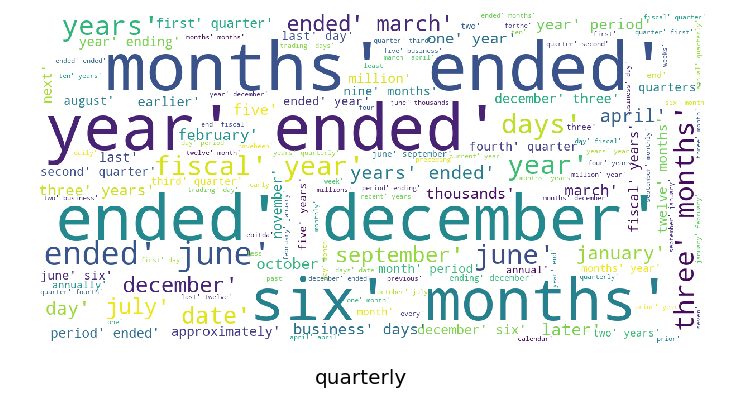

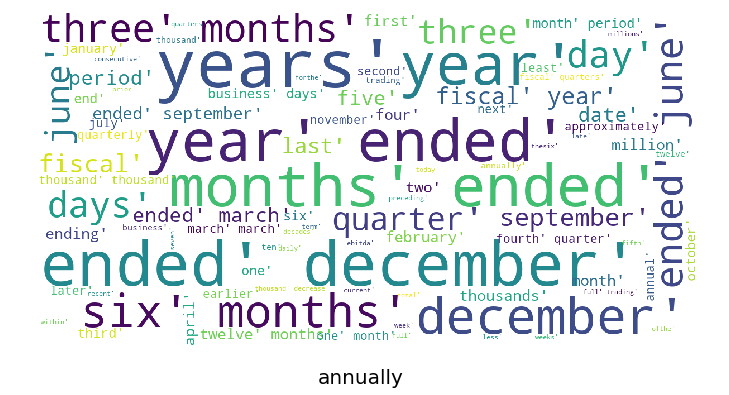

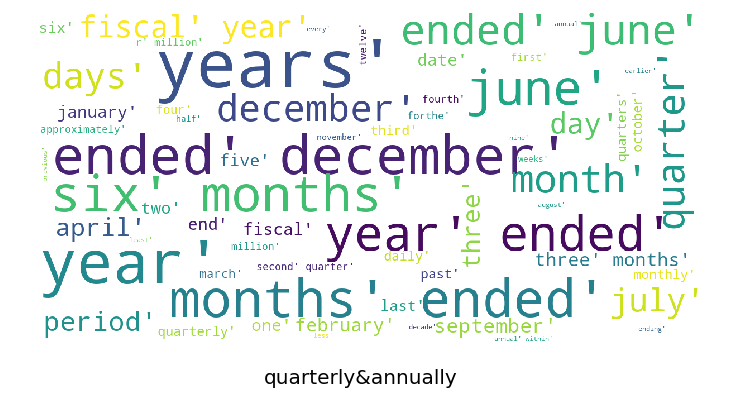

In [296]:
show_wordcloud(quarter,"quarterly")
show_wordcloud(annual,"annually")
show_wordcloud(both,"quarterly&annually")

In [16]:
textdftest['Docid']=pd.to_numeric(textdftest.Docid)

In [17]:
final_textdf_test=pd.merge(textdftest,sec_metadata,left_on = 'Docid', right_on = 'VersionId')

In [18]:
final_textdf_test.shape

(1080, 4)

In [19]:
final_textdf.head(6)

,Docid,Text,VersionId,PeriodType
0,230288860,check smaller reporting company emerging growt...,230288860,Quarter
1,230292662,mid america apartment communitiesinc albert mc...,230292662,Annual
2,230292662,mid america apartment communitiesinc albert mc...,230292662,Quarter
3,230292662,mid america apartment communitiesinc albert mc...,230292662,NaN
4,242236708,united states securities exchange commission w...,242236708,Quarter
5,243576070,page packagedbeverage latin america beverages ...,243576070,Annual


In [274]:
final_textdf=final_textdf.drop(columns="VersionId")

In [275]:
final_textdf.head(2)

,Docid,Text,PeriodType
0,230288860,check smaller reporting company emerging growt...,Quarter
1,230292662,mid america apartment communitiesinc albert mc...,Annual


In [277]:
len(final_textdf)

2017

In [24]:
Annual=[]
for i in range(len(final_textdf)):
    print(i)
    if final_textdf["PeriodType"].iloc[i]=="Annual":
        for word in final_textdf["Text"].iloc[i].split():
            Annual.append(word)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [25]:
Counter(Annual).most_common()

[('company', 57605),
 ('1', 52154),
 ('shares', 46210),
 ('stock', 40763),
 ('financial', 40353),
 ('2', 37034),
 ('may', 31451),
 ('december', 29932),
 ('3', 29786),
 ('common', 29246),
 ('agreement', 28992),
 ('ended', 28389),
 ('4', 25881),
 ('value', 25066),
 ('tax', 25046),
 ('000', 24196),
 ('shall', 23320),
 ('business', 22892),
 ('5', 22610),
 ('year', 22317),
 ('cash', 22277),
 ('share', 21275),
 ('31', 21221),
 ('notes', 21148),
 ('consolidated', 20959),
 ('date', 20889),
 ('securities', 20819),
 ('assets', 20357),
 ('0', 19836),
 ('interest', 19349),
 ('june', 18746),
 ('2017', 18725),
 ('statements', 17911),
 ('amount', 17891),
 ('total', 17837),
 ('income', 17749),
 ('f', 17371),
 ('6', 17301),
 ('8', 16670),
 ('7', 16525),
 ('net', 16477),
 ('10', 15962),
 ('merger', 15651),
 ('fair', 15601),
 ('term', 14840),
 ('related', 14332),
 ('2018', 14307),
 ('30', 14187),
 ('time', 13986),
 ('credit', 13983),
 ('u', 13978),
 ('party', 13905),
 ('price', 13824),
 ('per', 13817),
 

In [404]:
vec =TfidfVectorizer(ngram_range=(1,3))

In [405]:
tfidf = vec.fit_transform(final_textdf_test.Text.values)

In [369]:
final_textdf_test.Text[0]

'forthe quarter ended december december december december quarter year ended december three months ended december february three months ended three months ended december december year ended december thousands december december four quarters fourth quarter year end prior year june million fourth quarter thousands december three months ended december year ended december thousands three months ended year ended december one month april occupancy quarter year year full year late april late july late october early february today fadof million year ended december aparticular quarter seasonal three months ended december three months ended december thousands three months ended year ended december september thousands december three months november fiscal year quarter ended december fourth quarter thursday age years thousands three months ended december year ended december end fourth quarter october july end ofthe fourth quarter quarter average quarter end three months ended december year thousan

In [406]:
vec.get_feature_names()[0:20]

['absorbed',
 'absorbed previous',
 'absorbed previous years',
 'accumulated',
 'accumulated year',
 'accumulated year core',
 'achieved',
 'achieved three',
 'achieved three years',
 'activecustomers',
 'activecustomers first',
 'activecustomers first quarter',
 'actual',
 'actual fourth',
 'actual fourth quarter',
 'actuntil',
 'actuntil days',
 'actuntil days february',
 'aday',
 'aday june']

In [407]:
unseen_tfidf = vec.transform(final_textdf_train.Text.values)

In [410]:
x=tfidf.toarray()
y=final_textdf_test.PeriodType.values

In [350]:
final_textdf_test.head(2)

,Docid,Text,PeriodType,Category
0,230292662,forthe quarter ended december december decembe...,1,TEST
1,350666530,thirty day years ended december three months e...,2,TEST


In [421]:
clf = MultinomialNB(alpha=0.0000001)
clf.fit(x,y)

MultinomialNB(alpha=1e-07, class_prior=None, fit_prior=True)

In [422]:
predict_y = clf.predict(unseen_tfidf)

In [423]:
predict_y

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 2], dtype=int64)

In [420]:
final_textdf_train.PeriodType.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 3, 2, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 1, 2, 2, 2, 1, 1, 1, 1], dtype=int64)

In [380]:
y

array([1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 1, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 2, 2, 2], dtype=int64)

In [427]:
from sklearn.linear_model import SGDClassifier
clf1 = SGDClassifier(alpha=0.0000001, penalty='l2', loss='log', random_state=42)
clf1.fit(x, y)

C:\Users\lingadhar_duggirala\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=1e-07, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [428]:
y_predict_log=clf1.predict(unseen_tfidf)

In [429]:
y_predict_log

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 2], dtype=int64)

In [73]:
lst=[]
with open ('230288860.txt', 'rt') as in_file:
    for line in in_file:
        if line.startswith('          ') == True:
            if not re.match("^[a-zA-Z0-9_]*$", line):
                lst.append(line)

In [74]:
lst=[re.sub('[^a-zA-Z0-9\n]', ' ', line) for line in lst]
lst=[re.sub('\n', ' ', line) for line in lst]

In [75]:
data=" ".join(lst)

In [76]:
data

'                              check if                                a smaller                                reporting                                company                                             Emerging growth company    o                                                                                                                   Page            PART I FINANCIAL INFORMATION            Consolidated Statements of Income for the Three Months Ended December 31  2017 and 2016                2            Consolidated Statements of Comprehensive Income for the Three Months Ended December 31  2017 and 2016  3            Consolidated Balance Sheets at December 31  2017  and September 30  2017                               4            Consolidated Statements of Cash Flow for the Three Months Ended December 31  2017 and 2016             5            Condensed Notes to Consolidated Financial Statements                                                   6            PART II OTHER IN

In [65]:
txt=nlp(data)
orgs=list(set([(X.text).lower() for X in txt.ents if (X.label_=='ORG')]))
orgs=[x for x in orgs if (len(x.split())>1)]
removetable = str.maketrans('', '', ')(+[]')
orgs=[s.translate(removetable) for s in orgs]
orgs

['the consolidated statement of operations                     net revenue                                                                                                   ',
 'months ended                                                      ',
 'the                             facility  ',
 'accumulated other comprehensive income',
 'exhibit 3 2',
 'consolidated        parent          ',
 ' the process equipment group',
 ' leverage ratio   ',
 'adopted accounting standards',
 '9                  2 5',
 'pension and         currency',
 '7                                              batesville',
 '            0 2                                                     interest',
 '0                                              business',
 '7                                              depreciation',
 'process equipment group',
 '                                                                  pension and         currency',
 'leverage                             ratio',
 '9             

In [66]:
info=list(set([(X.text,X.label_) for X in txt.ents]))

In [69]:
info

[('328', 'CARDINAL'),
 ('Three Months Ended December 31  2017', 'DATE'),
 ('                                     0 5', 'PERSON'),
 ('INC                                  ', 'GPE'),
 ('125', 'CARDINAL'),
 ('127', 'CARDINAL'),
 ('63 1', 'CARDINAL'),
 ('450', 'CARDINAL'),
 ('                                                                               Recognized',
  'PERSON'),
 ('             41 6', 'PERSON'),
 (' 4 1                 1', 'ORG'),
 ('             72 6             3 6              ', 'PERSON'),
 ('                                                                         Hillenbrand',
  'PERSON'),
 ('                                                                  Derivative',
  'ORG'),
 ('                      Incorporated', 'ORG'),
 ('December 31                                                                                                    2017',
  'DATE'),
 ('9', 'CARDINAL'),
 ('                                 ', 'PERSON'),
 ('three year period', 'DATE'),
 ('        

In [71]:
[x for x in dates if len(x)>8]

['years\n                  september 30, 2017',
 'december 15, 2017',
 'march\n            31, 2017',
 'september 30, 2017',
 'sep. 30, 2016',
 'years\n               ',
 'the 6 months ended september 30',
 'august 4, 2016',
 'september 25, 2017',
 '            nov. 20, 2017',
 'july 28, 2016',
 'september 30,',
 'a full year',
 'five years',
 'march\n                                                               31, 2017',
 'march 31, 2017\n                                                   september 30, 2017    march 31, 2017',
 'sep. 30, 2017\n                                      ',
 'the year ended march 31, 2018',
 'september 30',
 'september 2017',
 'march 31, 2017\n               ',
 'september 30, 2016',
 '2017                ',
 'the six months ended\n            september 30, 2017 and 2016',
 'october 28, 2014',
 'sep. 30, 2017  ',
 'march\n                                                                                               31, 2017',
 'may 13, 1982, july 6, 2006, 

In [99]:
x = ["Jan", "Mar", "Feb", "May", "Apr"]

In [101]:
x.index("Feb")

2